PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

Please note that this notebook relies on a pytorch data loader implementation which is only available from icenet v0.2.8+.

To install the necessary python packages, you can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + CUDA + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of UnetDiffusion
Maria Carolina Novitasari

#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

### How to Download Daily Data for IceNet

#### DOWNLOAD SIC Data  

To download Sea Ice Concentration (SIC) data, modify the script below with the desired date range:

```python
sic = SICDownloader(
    dates=[
        pd.to_datetime(date).date()  # Dates to download SIC data for
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    delete_tempfiles=True,           # Delete temporary downloaded files after use
    north=False,                     # Use mask for the Northern Hemisphere (set to True if needed)
    south=True,                      # Use mask for the Southern Hemisphere
    parallel_opens=True,             # Enable parallel processing with dask.delayed
)

sic.download()
```

#### Download ERA5 Data  

##### Setup ERA5 API

Use the following link to set up the ERA5 API: [https://cds.climate.copernicus.eu/how-to-api?](https://cds.climate.copernicus.eu/how-to-api?).

Run the following script with your desired dates:

#### ERA5 Downloader  

```python
import pandas as pd
from icenet.data.interfaces.cds import ERA5Downloader

era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],      # Name of variables to download
    dates=[                                     # Dates to download the variable data for
        pd.to_datetime(date).date()
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    path="./data",                              # Location to download data to (default is `./data`)
    delete_tempfiles=True,                      # Whether to delete temporary downloaded files
    levels=[None, [250, 500], None, None],      # The levels at which to obtain the variables for (e.g. for zg, it is the pressure levels)
    max_threads=4,                              # Maximum number of concurrent downloads
    north=False,                                # Boolean: Whether require data across northern hemisphere
    south=True,                                 # Boolean: Whether require data across southern hemisphere
    use_toolbox=False)                          # Experimental, alternative download method

era5.download()                                 # Start downloading
```

The prototype data currently in use (South Pole, 2020) can be downloaded from **Baskerville** at the following path: `/vjgo8416-ice-frcst/shared/prototype_data/`

In [2]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Tuple
from torchmetrics import Metric
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

## 1. Download

In [3]:
import numpy
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

In [4]:
# Unset SLURM_NTASKS if it's causing issues
if "SLURM_NTASKS" in os.environ:
    del os.environ["SLURM_NTASKS"]

# Optionally, set SLURM_NTASKS_PER_NODE if needed
os.environ["SLURM_NTASKS_PER_NODE"] = "1"  # or whatever value is appropriate

### Mask data

Create masks for masking data.

In [5]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [6]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

# era5.download()

2025-03-27 17:35:37,474 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-27 17:35:37,478 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
INFO:root:Upping connection limit for max_threads > 10


In [7]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

# sic.download()

Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [8]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [9]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [10]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

2025-03-27 17:35:42.706781: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 17:35:44.192062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 17:35:44.192168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 17:35:44.280116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 17:35:44.365656: I tensorflow/core/platform/cpu_feature_guar

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [11]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for tas
INFO:root:Got 1 files for uas
INFO:root:Got 1 files for vas
INFO:root:Got 1 files for zg250
INFO:root:Got 1 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [12]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [13]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [14]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

In [15]:
batch_size = 4
shuffle = False
persistent_workers=True
num_workers = 4

## 3. Train

We implement a custom PyTorch class for training.

## IceNet2 U-Net Diffusion model

Maria's work (PyTorch Diffusion using U-Net)

In [16]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

In [17]:
class GaussianDiffusion:
    def __init__(self, timesteps: int = 1000, beta_schedule: str = 'linear'):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            self.betas = torch.linspace(1e-4, 0.02, timesteps)
        elif beta_schedule == 'cosine':
            self.betas = self._cosine_beta_schedule(timesteps)
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
    
    def _cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)
    
    def q_sample(self, x_start: torch.Tensor, t: torch.Tensor, noise: torch.Tensor = None) -> torch.Tensor:
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def p_sample(self, x: torch.Tensor, t: torch.Tensor, pred_noise: torch.Tensor) -> torch.Tensor:
        """Reverse diffusion process single step"""
        betas_t = self._extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self._extract(self.sqrt_recip_alphas, t, x.shape)
        
        # Equation 11 in the paper (our pred_noise is εθ)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)
        
        # Create mask for where t == 0
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        
        # Only add noise if t != 0
        posterior_variance_t = self._extract(self.posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + nonzero_mask * torch.sqrt(posterior_variance_t) * noise
    
    def _extract(self, a: torch.Tensor, t: torch.Tensor, x_shape: Tuple[int]) -> torch.Tensor:
        batch_size = t.shape[0]
        out = a.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [18]:
#mc
class UNetDiffusion(nn.Module):
    def __init__(self,
                 input_channels,
                 filter_size=3,
                 n_filters_factor=1,
                 n_forecast_days=7,
                 n_output_classes=1,
                 timesteps=1000,
                 **kwargs):
        super(UNetDiffusion, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes
        self.timesteps = timesteps
        
        # Time embedding
        self.time_embed_dim = 256
        self.time_embed = nn.Sequential(
            nn.Linear(self.time_embed_dim, self.time_embed_dim * 4),
            nn.SiLU(),
            nn.Linear(self.time_embed_dim * 4, self.time_embed_dim),
        )
        
        # Channel calculations
        start_out_channels = 64
        reduced_channels = self._make_divisible(int(start_out_channels * n_filters_factor), 8)
        channels = {
            start_out_channels * 2**pow: self._make_divisible(reduced_channels * 2**pow, 8)
            for pow in range(4)
        }

        # First conv block input channels calculation
        # x: [b,h,w,n_classes,n_days] -> after reshape: [b,h,w,n_classes*n_days]
        # y: [b,h,w,input_channels]
        # After concat: [b,h,w,(n_classes*n_days)+input_channels]
        self.initial_conv_channels = (n_output_classes * n_forecast_days) + input_channels
        
        # Encoder
        self.conv1 = self.conv_block(self.initial_conv_channels, channels[64])
        self.conv2 = self.conv_block(channels[64], channels[128])
        self.conv3 = self.conv_block(channels[128], channels[256])
        self.conv4 = self.conv_block(channels[256], channels[256])

        # Bottleneck
        self.conv5 = self.bottleneck_block(channels[256], channels[512])

        # Decoder
        self.up6 = self.upconv_block(channels[512], channels[256])
        self.up7 = self.upconv_block(channels[256], channels[256])
        self.up8 = self.upconv_block(channels[256], channels[128])
        self.up9 = self.upconv_block(channels[128], channels[64])

        self.up6b = self.conv_block(channels[512] + self.time_embed_dim, channels[256])
        self.up7b = self.conv_block(channels[512] + self.time_embed_dim, channels[256])
        self.up8b = self.conv_block(channels[256] + self.time_embed_dim, channels[128])
        self.up9b = self.conv_block(channels[128] + self.time_embed_dim, channels[64], final=True)

        # Final layer
        self.final_layer = nn.Conv2d(channels[64], n_output_classes * n_forecast_days, kernel_size=1, padding="same")

    def forward(self, x, t, y):
        """
        Forward pass that handles:
        - x: [batch, height, width, n_classes, n_forecast_days] noisy input
        - t: [batch] timesteps
        - y: [batch, height, width, input_channels] conditional input
        Returns: [batch, height, width, n_classes, n_forecast_days]
        """
        # Time embedding
        t = self._timestep_embedding(t)
        t = self.time_embed(t)
        
        # Reshape x to merge forecast days dimension
        orig_shape = x.shape
        x = x.permute(0,1,2,4,3)  # [b,h,w,d,c]
        x = x.reshape(*x.shape[:3], -1)  # [b,h,w,d*c]
        
        # Concatenate with conditional input
        x = torch.cat([x, y], dim=-1)  # [b,h,w,(d*c)+input_channels]
        
        # Convert to channel-first format
        x = torch.movedim(x, -1, 1)  # [b,channels,h,w]

        # Encoder pathway
        bn1 = self.conv1(x)
        conv1 = F.max_pool2d(bn1, kernel_size=2)
        bn2 = self.conv2(conv1)
        conv2 = F.max_pool2d(bn2, kernel_size=2)
        bn3 = self.conv3(conv2)
        conv3 = F.max_pool2d(bn3, kernel_size=2)
        bn4 = self.conv4(conv3)
        conv4 = F.max_pool2d(bn4, kernel_size=2)

        # Bottleneck
        bn5 = self.conv5(conv4)

        # Decoder with time embedding
        up6 = self.up6(bn5)
        up6 = torch.cat([bn4, up6], dim=1)
        up6 = self._add_time_embedding(up6, t)
        up6 = self.up6b(up6)
        
        up7 = self.up7(up6)
        up7 = torch.cat([bn3, up7], dim=1)
        up7 = self._add_time_embedding(up7, t)
        up7 = self.up7b(up7)
        
        up8 = self.up8(up7)
        up8 = torch.cat([bn2, up8], dim=1)
        up8 = self._add_time_embedding(up8, t)
        up8 = self.up8b(up8)
        
        up9 = self.up9(up8)
        up9 = torch.cat([bn1, up9], dim=1)
        up9 = self._add_time_embedding(up9, t)
        up9 = self.up9b(up9)

        # Final output
        output = self.final_layer(up9)  # [b, c_out, h, w]
        output = torch.movedim(output, 1, -1)  # [b, h, w, c_out]
        
        # Reshape back to original format
        output = output.reshape(orig_shape[0], orig_shape[1], orig_shape[2], 
                              self.n_forecast_days, self.n_output_classes)
        output = output.permute(0,1,2,4,3)  # [b,h,w,c,d]
        
        return output
        
    def _make_divisible(self, v, divisor):
        """Ensure v is divisible by divisor"""
        return max(divisor, (v // divisor) * divisor)

    def _get_num_groups(self, channels):
        """Calculate maximum number of groups that divides channels"""
        num_groups = 8  # Start with preferred group count
        while num_groups > 1:
            if channels % num_groups == 0:
                return num_groups
            num_groups -= 1
        return 1  # Fallback to GroupNorm(1,...) which is equivalent to LayerNorm

    def _timestep_embedding(self, timesteps, dim=256, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding
    
    def _add_time_embedding(self, x, t):
        b, c, h, w = x.shape
        t = t.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, h, w)
        return torch.cat([x, t], dim=1)
    
    def conv_block(self, in_channels, out_channels, final=False):
        num_groups = self._get_num_groups(out_channels)
        
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(),
        ]
        if not final:
            return nn.Sequential(*layers)
        else:
            final_layers = [
                nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
                nn.GroupNorm(num_groups, out_channels),
                nn.SiLU(),
            ]
            return nn.Sequential(*(layers + final_layers))

    def bottleneck_block(self, in_channels, out_channels):
        num_groups = self._get_num_groups(out_channels)
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(),
        )

    def upconv_block(self, in_channels, out_channels):
        num_groups = self._get_num_groups(out_channels)
        return nn.Sequential(
            Interpolate(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same"),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU()
        )

Define custom metrics for use in validation and monitoring

In [20]:
class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long() 
        target = (target > 0.15).long() 
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long()
        target = (target > 0.15).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

Define custom loss functions

In [21]:
class WeightedBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted BCEWithLogitsLoss loss.

        Compute BCEWithLogitsLoss loss weighted by masking.

        Using BCEWithLogitsLoss instead of BCELoss, as pytorch docs mentions it is
        more numerically stable.
        https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        
        """
        # Computing using nn.BCEWithLogitsLoss base class. This class must be instantiated via:
        # >>> criterion = WeightedBCEWithLogitsLoss(reduction='none')
        loss = super().forward(
                            (inputs.movedim(-2, 1)),
                            (targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedL1Loss(nn.L1Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted L1 loss.

        Compute L1 loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.L1Loss class. This class must be instantiated via:
        # >>> criterion = WeightedL1Loss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)
        
        return loss.mean()

class WeightedMSELoss(nn.MSELoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, inputs, targets, sample_weights):
        """
        Weighted MSE loss.

        Compute MSE loss weighted by masking.
        
        """
        y_hat = torch.sigmoid(inputs)

        # Computing using nn.MSELoss base class. This class must be instantiated via:
        # criterion = nn.MSELoss(reduction="none")
        loss = super().forward(
                            (100*y_hat.movedim(-2, 1)), 
                            (100*targets.movedim(-1, 1))
                         )*sample_weights.movedim(-1, 1)

        return loss.mean()

A _LightningModule_ wrapper for UNetDiffusion model.

Function for training UNetDiffusion model using PyTorch Lightning.

In [24]:
#mc

class LitDiffusion(pl.LightningModule):
    def __init__(self,
                 model: nn.Module,
                 learning_rate: float,
                 timesteps: int = 1000):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.timesteps = timesteps
        self.diffusion = GaussianDiffusion(timesteps=timesteps)
        
        # Maintain original metrics
        self.n_output_classes = model.n_output_classes
        self.n_forecast_days = model.n_forecast_days
        
        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.n_forecast_days))),
            "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.n_forecast_days)))
        }
        for i in range(self.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.n_forecast_days))),
            "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.n_forecast_days)))
        }
        for i in range(self.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)
        
        self.save_hyperparameters()
   
    def forward(self, x):
        """Handle both single inputs and dataloader batches"""
        if isinstance(x, (list, tuple)):
            x = x[0]  # Extract input features from batch tuple
        elif not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device)
        return self.sample(x)
        
    def training_step(self, batch):
        x, y, sample_weight = batch
        
        # Sample random timesteps
        t = torch.randint(0, self.timesteps, (x.shape[0],), device=x.device).long()
        
        # Prepare target (add forecast days dimension if needed)
        if y.dim() == 4:
            y = y.unsqueeze(-1).expand(-1, -1, -1, -1, self.n_forecast_days)
        
        # Create noisy version
        noise = torch.randn_like(y)
        noisy_y = self.diffusion.q_sample(y, t, noise)
        
        # Predict the noise
        pred_noise = self.model(noisy_y, t, x)
        
        # Calculate loss
        loss = F.mse_loss(pred_noise, noise)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, y, sample_weight = batch
        
        # Generate samples
        generated = self.sample(x)
        generated = torch.sigmoid(generated)
        
        # Prepare target
        if y.dim() == 4:
            y = y.unsqueeze(-1).expand(-1, -1, -1, -1, self.n_forecast_days)
        
        # Calculate loss
        loss = F.mse_loss(generated, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        
        # Update metrics
        self.metrics.update(generated.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))
        return loss

    def sample(self, x, num_samples=1):
        """Generate samples using diffusion process"""
        shape = (x.shape[0], *x.shape[1:-1], self.n_output_classes, self.n_forecast_days)
        device = x.device
        
        # Start from pure noise
        y = torch.randn(shape, device=device)
        
        for t in reversed(range(0, self.timesteps)):
            t_batch = torch.full((x.shape[0],), t, device=device, dtype=torch.long)
            pred_noise = self.model(y, t_batch, x)
            y = self.diffusion.p_sample(y, t_batch, pred_noise)
            
        return y

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y, sample_weight = batch
        
        # Generate samples
        generated = self.sample(x)
        generated = torch.sigmoid(generated)
        
        # Calculate loss (optional)
        loss = F.mse_loss(generated, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        
        self.test_metrics.update(generated.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True, sync_dist=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """Special prediction handling that properly unpacks batches"""
        # Get input features
        x = batch[0] if isinstance(batch, (list, tuple)) else batch
        
        # Convert to tensor if needed
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device)
            
        # Generate and return predictions
        return self(x)  # This goes through forward() -> sample()

In [25]:
from lightning.pytorch.callbacks import ModelCheckpoint

def train_diffusion_icenet(configuration_path,
                          learning_rate,
                          max_epochs,
                          batch_size,
                          n_workers,
                          filter_size,
                          n_filters_factor,
                          seed,
                          timesteps=1000):
    """
    Train IceNet diffusion model using the specified parameters.
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                 persistent_workers=persistent_workers, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                               persistent_workers=persistent_workers, shuffle=False)

    # construct diffusion model
    model = UNetDiffusion(
        input_channels=train_dataset._num_channels,
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._n_forecast_days,
        timesteps=timesteps
    )
    
    # configure PyTorch Lightning module
    lit_module = LitDiffusion(
        model=model,
        learning_rate=learning_rate,
        timesteps=timesteps
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=1,
        fast_dev_run=False,
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return model, trainer, checkpoint_callback

Conduct actual training run.

In [ ]:
seed = 45

#mc
model, trainer, checkpoint_callback = train_diffusion_icenet(
    configuration_path=dataset_config,
    learning_rate=1e-4,
    max_epochs=10,
    batch_size=batch_size,
    n_workers=num_workers,
    filter_size=3,
    n_filters_factor=0.4,
    seed=seed,
    timesteps=1000
)

INFO: [rank: 0] Seed set to 45
INFO:lightning.fabric.utilities.seed:[rank: 0] Seed set to 45
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/notebook_binder_1/67a1e320-7c47-4ea9-8df8-e868326bc90b/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/notebook_binder_1/67a1e320-7c47-4ea9-8df8-e868326bc90b/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightnin

Training 91 examples / 23 batches (batch size 4).
Validating 21 examples / 6 batches (batch size 4).


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | UNetDiffusion    | 2.7 M  | train
1 | metrics      | MetricCollection | 0      | train
2 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.725    Total estimated model params size (MB)
126       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | UNetDiffusion    | 2.7 M  | train
1 | metrics      | MetricCollection | 0      | train
2 | test_metrics | MetricCollection | 0      | train
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]                            

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:   4%|▍         | 1/23 [00:02<01:02,  0.35it/s, v_num=996583, train_loss_step=1.120]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  17%|█▋        | 4/23 [00:03<00:14,  1.27it/s, v_num=996583, train_loss_step=1.040]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  22%|██▏       | 5/23 [00:04<00:16,  1.11it/s, v_num=996583, train_loss_step=1.040]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  22%|██▏       | 5/23 [00:04<00:16,  1.11it/s, v_num=996583, train_loss_step=1.040]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  26%|██▌       | 6/23 [00:05<00:14,  1.18it/s, v_num=996583, train_loss_step=1.040]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  35%|███▍      | 8/23 [00:05<00:10,  1.50it/s, v_num=996583, train_loss_step=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  39%|███▉      | 9/23 [00:06<00:10,  1.33it/s, v_num=996583, train_loss_step=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  43%|████▎     | 10/23 [00:07<00:09,  1.36it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  52%|█████▏    | 12/23 [00:08<00:07,  1.46it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  57%|█████▋    | 13/23 [00:08<00:06,  1.46it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  61%|██████    | 14/23 [00:09<00:06,  1.47it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  65%|██████▌   | 15/23 [00:10<00:05,  1.43it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  70%|██████▉   | 16/23 [00:10<00:04,  1.51it/s, v_num=996583, train_loss_step=1.010]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  74%|███████▍  | 17/23 [00:11<00:04,  1.49it/s, v_num=996583, train_loss_step=1.000]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  78%|███████▊  | 18/23 [00:11<00:03,  1.54it/s, v_num=996583, train_loss_step=1.000]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0:  87%|████████▋ | 20/23 [00:13<00:01,  1.53it/s, v_num=996583, train_loss_step=1.000]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, v_num=996583, train_loss_step=1.000]

/tmp/ipykernel_78139/2959529059.py:67: UserWarning: Using a target size (torch.Size([3, 432, 432, 7, 1])) that is different to the input size (torch.Size([3, 432, 432, 1, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred_noise, noise)



Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 0: 100%|██████████| 23/23 [02:45<00:00,  0.14it/s, v_num=996583, train_loss_step=1.000, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/tmp/ipykernel_78139/2959529059.py:84: UserWarning: Using a target size (torch.Size([1, 432, 432, 7, 1])) that is different to the input size (torch.Size([1, 432, 432, 1, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated, y)


Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=1.000, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:   4%|▍         | 1/23 [00:02<01:01,  0.36it/s, v_num=996583, train_loss_step=1.000, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  17%|█▋        | 4/23 [00:03<00:14,  1.29it/s, v_num=996583, train_loss_step=0.999, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  22%|██▏       | 5/23 [00:05<00:18,  0.99it/s, v_num=996583, train_loss_step=0.999, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  35%|███▍      | 8/23 [00:05<00:09,  1.50it/s, v_num=996583, train_loss_step=0.998, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  39%|███▉      | 9/23 [00:07<00:11,  1.24it/s, v_num=996583, train_loss_step=0.998, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.996, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  61%|██████    | 14/23 [00:09<00:06,  1.48it/s, v_num=996583, train_loss_step=0.997, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.996, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  74%|███████▍  | 17/23 [00:11<00:04,  1.48it/s, v_num=996583, train_loss_step=0.993, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  78%|███████▊  | 18/23 [00:11<00:03,  1.55it/s, v_num=996583, train_loss_step=0.994, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  87%|████████▋ | 20/23 [00:11<00:01,  1.69it/s, v_num=996583, train_loss_step=0.993, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1: 100%|██████████| 23/23 [00:13<00:00,  1.65it/s, v_num=996583, train_loss_step=0.990, val_accuracy=50.10, val_accuracy_0=49.80, val_accuracy_1=49.40, val_accuracy_2=50.40, val_accuracy_3=50.30, val_accuracy_4=49.80, val_accuracy_5=50.30, val_accuracy_6=50.50, val_sieerror=7.54e+9, val_sieerror_0=1.1e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.06e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.05e+9, val_sieerror_6=1.02e+9, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.990, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:   4%|▍         | 1/23 [00:02<00:59,  0.37it/s, v_num=996583, train_loss_step=0.987, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  13%|█▎        | 3/23 [00:02<00:19,  1.03it/s, v_num=996583, train_loss_step=0.987, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  17%|█▋        | 4/23 [00:03<00:14,  1.29it/s, v_num=996583, train_loss_step=0.985, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:  26%|██▌       | 6/23 [00:04<00:14,  1.21it/s, v_num=996583, train_loss_step=0.983, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  30%|███       | 7/23 [00:05<00:11,  1.37it/s, v_num=996583, train_loss_step=0.981, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  35%|███▍      | 8/23 [00:05<00:09,  1.51it/s, v_num=996583, train_loss_step=0.982, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:  43%|████▎     | 10/23 [00:07<00:09,  1.39it/s, v_num=996583, train_loss_step=0.976, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  48%|████▊     | 11/23 [00:07<00:07,  1.50it/s, v_num=996583, train_loss_step=0.978, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  52%|█████▏    | 12/23 [00:07<00:06,  1.61it/s, v_num=996583, train_loss_step=0.969, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:  61%|██████    | 14/23 [00:09<00:05,  1.50it/s, v_num=996583, train_loss_step=0.969, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  65%|██████▌   | 15/23 [00:09<00:05,  1.58it/s, v_num=996583, train_loss_step=0.972, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  70%|██████▉   | 16/23 [00:09<00:04,  1.67it/s, v_num=996583, train_loss_step=0.965, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:  74%|███████▍  | 17/23 [00:11<00:04,  1.43it/s, v_num=996583, train_loss_step=0.964, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  87%|████████▋ | 20/23 [00:12<00:01,  1.66it/s, v_num=996583, train_loss_step=0.963, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  87%|████████▋ | 20/23 [00:12<00:01,  1.65it/s, v_num=996583, train_loss_step=0.960, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2: 100%|██████████| 23/23 [00:14<00:00,  1.62it/s, v_num=996583, train_loss_step=0.955, val_accuracy=49.80, val_accuracy_0=49.80, val_accuracy_1=49.30, val_accuracy_2=50.50, val_accuracy_3=49.90, val_accuracy_4=49.70, val_accuracy_5=49.30, val_accuracy_6=49.80, val_sieerror=7.69e+9, val_sieerror_0=1.09e+9, val_sieerror_1=1.15e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.11e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.08e+9, train_loss_epoch=0.996]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.955, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:   4%|▍         | 1/23 [00:02<00:57,  0.38it/s, v_num=996583, train_loss_step=0.955, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  17%|█▋        | 4/23 [00:02<00:14,  1.35it/s, v_num=996583, train_loss_step=0.953, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:  22%|██▏       | 5/23 [00:04<00:17,  1.03it/s, v_num=996583, train_loss_step=0.953, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  35%|███▍      | 8/23 [00:05<00:09,  1.54it/s, v_num=996583, train_loss_step=0.942, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:  39%|███▉      | 9/23 [00:07<00:11,  1.26it/s, v_num=996583, train_loss_step=0.941, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.937, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:  57%|█████▋    | 13/23 [00:09<00:07,  1.40it/s, v_num=996583, train_loss_step=0.946, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.934, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  70%|██████▉   | 16/23 [00:09<00:04,  1.64it/s, v_num=996583, train_loss_step=0.932, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:  74%|███████▍  | 17/23 [00:11<00:04,  1.48it/s, v_num=996583, train_loss_step=0.935, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  87%|████████▋ | 20/23 [00:11<00:01,  1.68it/s, v_num=996583, train_loss_step=0.927, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3: 100%|██████████| 23/23 [00:14<00:00,  1.64it/s, v_num=996583, train_loss_step=0.921, val_accuracy=50.00, val_accuracy_0=50.10, val_accuracy_1=50.00, val_accuracy_2=50.60, val_accuracy_3=49.90, val_accuracy_4=49.50, val_accuracy_5=50.40, val_accuracy_6=49.60, val_sieerror=7.62e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.1e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.08e+9, val_sieerror_4=1.15e+9, val_sieerror_5=1.04e+9, val_sieerror_6=1.11e+9, train_loss_epoch=0.973]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 4:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.921, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]           

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:   4%|▍         | 1/23 [00:02<00:57,  0.38it/s, v_num=996583, train_loss_step=0.921, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:   4%|▍         | 1/23 [00:02<00:58,  0.37it/s, v_num=996583, train_loss_step=0.920, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  17%|█▋        | 4/23 [00:02<00:13,  1.36it/s, v_num=996583, train_loss_step=0.916, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:  22%|██▏       | 5/23 [00:04<00:17,  1.03it/s, v_num=996583, train_loss_step=0.916, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  22%|██▏       | 5/23 [00:04<00:17,  1.02it/s, v_num=996583, train_loss_step=0.914, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  35%|███▍      | 8/23 [00:05<00:09,  1.54it/s, v_num=996583, train_loss_step=0.910, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:  39%|███▉      | 9/23 [00:07<00:11,  1.27it/s, v_num=996583, train_loss_step=0.910, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  48%|████▊     | 11/23 [00:07<00:08,  1.50it/s, v_num=996583, train_loss_step=0.906, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.906, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:  57%|█████▋    | 13/23 [00:09<00:07,  1.40it/s, v_num=996583, train_loss_step=0.906, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  65%|██████▌   | 15/23 [00:09<00:05,  1.58it/s, v_num=996583, train_loss_step=0.901, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.903, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:  74%|███████▍  | 17/23 [00:11<00:04,  1.49it/s, v_num=996583, train_loss_step=0.903, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  87%|████████▋ | 20/23 [00:11<00:01,  1.68it/s, v_num=996583, train_loss_step=0.899, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4: 100%|██████████| 23/23 [00:13<00:00,  1.66it/s, v_num=996583, train_loss_step=0.893, val_accuracy=50.00, val_accuracy_0=50.40, val_accuracy_1=49.90, val_accuracy_2=50.40, val_accuracy_3=49.80, val_accuracy_4=49.20, val_accuracy_5=50.20, val_accuracy_6=50.00, val_sieerror=7.7e+9, val_sieerror_0=1.05e+9, val_sieerror_1=1.12e+9, val_sieerror_2=1.1e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.17e+9, val_sieerror_5=1.08e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.939]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 5:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.893, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:   4%|▍         | 1/23 [00:02<00:57,  0.38it/s, v_num=996583, train_loss_step=0.893, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  17%|█▋        | 4/23 [00:02<00:14,  1.35it/s, v_num=996583, train_loss_step=0.892, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  22%|██▏       | 5/23 [00:04<00:17,  1.03it/s, v_num=996583, train_loss_step=0.892, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  35%|███▍      | 8/23 [00:05<00:09,  1.54it/s, v_num=996583, train_loss_step=0.887, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  52%|█████▏    | 12/23 [00:07<00:06,  1.61it/s, v_num=996583, train_loss_step=0.886, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  70%|██████▉   | 16/23 [00:09<00:04,  1.66it/s, v_num=996583, train_loss_step=0.886, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  87%|████████▋ | 20/23 [00:11<00:01,  1.69it/s, v_num=996583, train_loss_step=0.882, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5: 100%|██████████| 23/23 [00:14<00:00,  1.61it/s, v_num=996583, train_loss_step=0.880, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=51.20, val_accuracy_2=50.50, val_accuracy_3=49.50, val_accuracy_4=49.90, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.66e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.03e+9, val_sieerror_2=1.11e+9, val_sieerror_3=1.15e+9, val_sieerror_4=1.13e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 6:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.880, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:   9%|▊         | 2/23 [00:02<00:30,  0.69it/s, v_num=996583, train_loss_step=0.885, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  17%|█▋        | 4/23 [00:03<00:14,  1.30it/s, v_num=996583, train_loss_step=0.881, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:  35%|███▍      | 8/23 [00:05<00:09,  1.51it/s, v_num=996583, train_loss_step=0.881, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:  43%|████▎     | 10/23 [00:07<00:09,  1.36it/s, v_num=996583, train_loss_step=0.877, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:  57%|█████▋    | 13/23 [00:09<00:07,  1.39it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  61%|██████    | 14/23 [00:09<00:06,  1.47it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.876, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:  74%|███████▍  | 17/23 [00:11<00:04,  1.47it/s, v_num=996583, train_loss_step=0.876, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  78%|███████▊  | 18/23 [00:11<00:03,  1.55it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  87%|████████▋ | 20/23 [00:11<00:01,  1.68it/s, v_num=996583, train_loss_step=0.874, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, v_num=996583, train_loss_step=0.874, val_accuracy=50.50, val_accuracy_0=50.60, val_accuracy_1=50.80, val_accuracy_2=50.70, val_accuracy_3=50.40, val_accuracy_4=50.10, val_accuracy_5=50.30, val_accuracy_6=50.30, val_sieerror=7.57e+9, val_sieerror_0=1.06e+9, val_sieerror_1=1.06e+9, val_sieerror_2=1.08e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.889]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 7:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.874, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:   9%|▊         | 2/23 [00:02<00:29,  0.70it/s, v_num=996583, train_loss_step=0.874, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  17%|█▋        | 4/23 [00:03<00:14,  1.30it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:  22%|██▏       | 5/23 [00:04<00:17,  1.01it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  26%|██▌       | 6/23 [00:05<00:14,  1.18it/s, v_num=996583, train_loss_step=0.872, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  35%|███▍      | 8/23 [00:05<00:10,  1.49it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:  39%|███▉      | 9/23 [00:07<00:11,  1.22it/s, v_num=996583, train_loss_step=0.875, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  43%|████▎     | 10/23 [00:07<00:09,  1.33it/s, v_num=996583, train_loss_step=0.885, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  43%|████▎     | 10/23 [00:07<00:09,  1.33it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  52%|█████▏    | 12/23 [00:07<00:07,  1.54it/s, v_num=996583, train_loss_step=0.886, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:  57%|█████▋    | 13/23 [00:09<00:07,  1.35it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  61%|██████    | 14/23 [00:09<00:06,  1.44it/s, v_num=996583, train_loss_step=0.872, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  70%|██████▉   | 16/23 [00:09<00:04,  1.60it/s, v_num=996583, train_loss_step=0.876, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:  74%|███████▍  | 17/23 [00:11<00:04,  1.44it/s, v_num=996583, train_loss_step=0.881, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  78%|███████▊  | 18/23 [00:11<00:03,  1.51it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  87%|████████▋ | 20/23 [00:12<00:01,  1.65it/s, v_num=996583, train_loss_step=0.876, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7: 100%|██████████| 23/23 [00:14<00:00,  1.61it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.50, val_accuracy_0=50.50, val_accuracy_1=50.60, val_accuracy_2=50.80, val_accuracy_3=50.40, val_accuracy_4=50.30, val_accuracy_5=50.40, val_accuracy_6=50.30, val_sieerror=7.55e+9, val_sieerror_0=1.07e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.07e+9, val_sieerror_3=1.1e+9, val_sieerror_4=1.08e+9, val_sieerror_5=1.07e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.879]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 8:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:   4%|▍         | 1/23 [00:02<00:59,  0.37it/s, v_num=996583, train_loss_step=0.874, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  17%|█▋        | 4/23 [00:03<00:14,  1.33it/s, v_num=996583, train_loss_step=0.878, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:  22%|██▏       | 5/23 [00:04<00:17,  1.01it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  35%|███▍      | 8/23 [00:05<00:09,  1.51it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:  39%|███▉      | 9/23 [00:07<00:11,  1.26it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  52%|█████▏    | 12/23 [00:07<00:06,  1.60it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:  57%|█████▋    | 13/23 [00:09<00:07,  1.39it/s, v_num=996583, train_loss_step=0.873, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  70%|██████▉   | 16/23 [00:09<00:04,  1.64it/s, v_num=996583, train_loss_step=0.870, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:  78%|███████▊  | 18/23 [00:12<00:03,  1.49it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  83%|████████▎ | 19/23 [00:12<00:02,  1.56it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  87%|████████▋ | 20/23 [00:12<00:01,  1.63it/s, v_num=996583, train_loss_step=0.870, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.40, val_accuracy_1=50.80, val_accuracy_2=50.80, val_accuracy_3=50.20, val_accuracy_4=50.10, val_accuracy_5=49.90, val_accuracy_6=50.20, val_sieerror=7.6e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.06e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.1e+9, val_sieerror_5=1.12e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.878]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 9:   0%|          | 0/23 [00:00<?, ?it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:   4%|▍         | 1/23 [00:02<00:59,  0.37it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  17%|█▋        | 4/23 [00:03<00:14,  1.33it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  22%|██▏       | 5/23 [00:04<00:17,  1.02it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  22%|██▏       | 5/23 [00:04<00:17,  1.01it/s, v_num=996583, train_loss_step=0.871, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  35%|███▍      | 8/23 [00:05<00:09,  1.53it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  39%|███▉      | 9/23 [00:07<00:11,  1.27it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  39%|███▉      | 9/23 [00:07<00:11,  1.26it/s, v_num=996583, train_loss_step=0.867, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  48%|████▊     | 11/23 [00:07<00:08,  1.49it/s, v_num=996583, train_loss_step=0.867, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  52%|█████▏    | 12/23 [00:07<00:06,  1.59it/s, v_num=996583, train_loss_step=0.866, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  57%|█████▋    | 13/23 [00:09<00:07,  1.39it/s, v_num=996583, train_loss_step=0.867, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  65%|██████▌   | 15/23 [00:09<00:05,  1.57it/s, v_num=996583, train_loss_step=0.870, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  70%|██████▉   | 16/23 [00:09<00:04,  1.65it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  74%|███████▍  | 17/23 [00:11<00:04,  1.47it/s, v_num=996583, train_loss_step=0.870, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  87%|████████▋ | 20/23 [00:11<00:01,  1.68it/s, v_num=996583, train_loss_step=0.868, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9: 100%|██████████| 23/23 [00:14<00:00,  1.63it/s, v_num=996583, train_loss_step=0.869, val_accuracy=50.30, val_accuracy_0=50.30, val_accuracy_1=50.60, val_accuracy_2=50.40, val_accuracy_3=50.10, val_accuracy_4=50.20, val_accuracy_5=50.40, val_accuracy_6=50.20, val_sieerror=7.61e+9, val_sieerror_0=1.08e+9, val_sieerror_1=1.07e+9, val_sieerror_2=1.09e+9, val_sieerror_3=1.09e+9, val_sieerror_4=1.09e+9, val_sieerror_5=1.09e+9, val_sieerror_6=1.09e+9, train_loss_epoch=0.873]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

## 4. Prediction

Predicts using the best checkpoint from the training.

In [42]:
checkpoint_callback.best_k_models

{'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/notebook_binder_1/67a1e320-7c47-4ea9-8df8-e868326bc90b/lightning_logs/version_996583/checkpoints/epoch=6-step=161-v1.ckpt': tensor(0.4864)}

In [43]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/notebook_binder_1/67a1e320-7c47-4ea9-8df8-e868326bc90b/lightning_logs/version_996583/checkpoints/epoch=6-step=161-v1.ckpt'

In [44]:
# Load the best result from the checkpoint
# best_model = LitUNet.load_from_checkpoint(best_checkpoint)

#mc
best_model = LitDiffusion.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


LitDiffusion(
  (model): UNetDiffusion(
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (conv1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 48, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): GroupNorm(8, 48, eps=1e-05, affine=True)
      (5): SiLU()
    )
    (conv3): Sequential(
      (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 96, eps=1e

In [45]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=persistent_workers, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/notebook_binder_1/67a1e320-7c47-4ea9-8df8-e868326bc90b/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks

Testing: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Testing DataLoader 0: 100%|██████████| 1/1 [00:14<00:00,  0.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          50.21900939941406
     test_accuracy_0        50.733055114746094
     test_accuracy_1         50.60251235961914
     test_accuracy_2         50.04519271850586
     test_accuracy_3         50.32134246826172
     test_accuracy_4        49.926361083984375
     test_accuracy_5         49.62678146362305
     test_accuracy_6         50.27782440185547
        test_loss           0.49072781205177307
      test_sieerror             740059392.0
     test_sieerror_0            103706248.0
     test_sieerror_1            104830000.0
     test_sieerror_2            105685000.0
     test_sieerror_3            105355624.0
  

/tmp/ipykernel_78139/2959529059.py:118: UserWarning: Using a target size (torch.Size([2, 432, 432, 7, 1])) that is different to the input size (torch.Size([2, 432, 432, 1, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated, y)


[{'test_loss': 0.49072781205177307,
  'test_accuracy': 50.21900939941406,
  'test_accuracy_0': 50.733055114746094,
  'test_accuracy_1': 50.60251235961914,
  'test_accuracy_2': 50.04519271850586,
  'test_accuracy_3': 50.32134246826172,
  'test_accuracy_4': 49.926361083984375,
  'test_accuracy_5': 49.62678146362305,
  'test_accuracy_6': 50.27782440185547,
  'test_sieerror': 740059392.0,
  'test_sieerror_0': 103706248.0,
  'test_sieerror_1': 104830000.0,
  'test_sieerror_2': 105685000.0,
  'test_sieerror_3': 105355624.0,
  'test_sieerror_4': 106363128.0,
  'test_sieerror_5': 107871248.0,
  'test_sieerror_6': 106248128.0}]

In [46]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Predicting DataLoader 0: 100%|██████████| 1/1 [00:14<00:00,  0.07it/s]


In [47]:
for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([2, 432, 432, 1, 7])


## 5. Outputs and Plotting

Create prediction output directory

In [52]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset"
output_name = "example_pytorch_forecast_diff"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [53]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [54]:
!printf "2020-04-01\n2020-04-02" | tee testdates_diff.csv

2020-04-01
2020-04-02

In [55]:
!icenet_output -m -o results/predict example_pytorch_forecast_diff notebook_api_pytorch_data testdates_diff.csv

/bin/bash: icenet_output: command not found


Plotting the forecast

In [56]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [58]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast_diff.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

Animate result

In [59]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=(4,4), mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Check min/max of predicted SIC fraction

In [60]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: -877.5477, max: 952.6343


#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

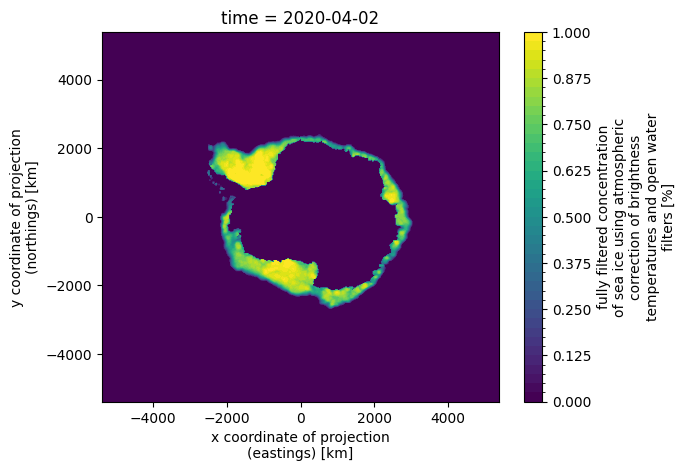

In [61]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=92).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.8